# Calculate the microburst CDF and PDF
Author: Mykahylo Shumko

In [1]:
import pandas as pd
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

In [2]:
WRITE_CDF_TO_FILE = True

CATALOG_VERSION = 6
CAT_PATH = ('/home/mike/research/ac6_microburst_scale_sizes/data/'
            'coincident_microbursts_catalogues/'
            'AC6_coincident_microbursts_sorted_Brady_v{}.txt'.format(CATALOG_VERSION))

# EXPOSURE_PATH = '/home/mike/research/ac6_microburst_scale_sizes/data/norm/ac6_norm_all_cdf.csv'
# EXPOSURE_PATH = '/home/mike/research/ac6_microburst_scale_sizes/data/norm/ac6_norm_all_2km_bins.csv'
# EXPOSURE_PATH = '/home/mike/research/ac6_microburst_scale_sizes/data/norm/ac6_norm_all_3km_bins.csv'
EXPOSURE_PATH = '/home/mike/research/ac6_microburst_scale_sizes/data/norm/ac6_norm_all_5km_bins_2km_offset.csv'
CDF_ERROR_PATH = '/home/mike/research/ac6_microburst_scale_sizes/data/cdf_std_v0.csv'

In [3]:
CC_THRESH = 0.8                   # Temporal CC threshold
CURTAIN_THRESH = 0                # Amount by which the temporal CC must be greater than the spatial CC.
PEAK_STD_THRESH = None            # The number of standard deviations that a detection must be above a 10% 
                                  # Paul baseline.
WIDTH_THRESH = None               # Width threshold in units of %/100.
MAX_SEP = 100                     # Maximum separation to use when calculating PDF and CDF.

## Load catalog

In [4]:
cat = pd.read_csv(CAT_PATH)

In [5]:
print(cat.shape); cat.head()

(662, 20)


,dateTime,dos1rate,peak_std,Lm_OPQ,MLT_OPQ,lat,lon,alt,Dist_In_Track,Lag_In_Track,Dist_Total,Loss_Cone_Type,flag,AE,time_cc,space_cc,time_spatial_A,time_spatial_B,peak_width_A,peak_width_B
0,2014-12-20 04:06:32.500000,230.001,2.523019,7.22304,9.59286,70.8986,71.127800,671.856,467.194,62.1174,467.451,1.0,4.0,88.0,0.838697,0.169975,2014-12-20 04:05:30.382600,2014-12-20 04:06:32.500000,NaN,0.683457
1,2015-03-30 08:30:29.699999,200.001,4.248539,6.71147,22.48060,-63.0605,-167.832000,702.558,218.684,29.1986,218.716,1.0,0.0,53.0,0.807756,-0.243157,2015-03-30 08:30:00.501399,2015-03-30 08:30:29.699999,0.200000,0.585546
2,2015-04-04 12:34:40.200000,640.003,2.826754,6.68557,10.60430,-75.4475,-0.796446,667.406,192.072,25.5132,192.095,0.0,0.0,490.0,0.891613,-0.088424,2015-04-04 12:34:40.200000,2015-04-04 12:35:05.713200,0.564084,0.731709
3,2015-04-04 14:11:35.100000,429.959,3.209049,7.60874,11.45280,-79.1931,-10.744800,671.100,191.976,25.5093,191.999,0.0,0.0,84.0,0.820881,-0.057296,2015-04-04 14:11:09.590700,2015-04-04 14:11:35.100000,0.657117,0.524206
4,2015-04-14 20:24:19.199999,399.962,3.328963,5.20606,13.12250,-70.4918,-127.485000,643.371,139.127,18.4175,139.134,1.0,0.0,606.0,0.863988,0.122827,2015-04-14 20:24:00.782499,2015-04-14 20:24:19.199999,NaN,0.807220


As a reference, what is the number of valid spatial and temporal CCs?

In [6]:
cat[(~np.isnan(cat['time_cc'])) & (~np.isnan(cat['space_cc']))].shape[0]

662

And now out of all of these detections, how many events had a temporal CC above CC_THRESH?

In [7]:
cat[cat['time_cc'] > CC_THRESH].shape[0]

662

## Load sampling dataset
The number of AC-6 seconds taken between separations a and b is given by the exposure, $E(a, b)$. The exposure is calculated by finding all 10 Hz data that were taking simulatenorusly by units A and B. Furthermore the dos1rate data cannot be negative i.e. not -1E31 error values, and the data flag = 0.

In [8]:
E = pd.read_csv(EXPOSURE_PATH, index_col=0)
bin_width = E.index[1] - E.index[0]
bins = E.loc[0:MAX_SEP].index #np.arange(0, MAX_SEP+1, 2) # Separation bins

In [9]:
E.head()

,Seconds
Separation [km],
2,43057.1
7,26116.7
12,8459.6
17,15498.0
22,7695.4


## Load error dataset

In [10]:
ERR = pd.read_csv(CDF_ERROR_PATH, index_col=0)
ERR.head()

,std
d,
0.0,0.006905
5.0,0.011086
10.0,0.007376
15.0,0.006020
20.0,0.007518


## Find coincident events
I define events that are coincident by the following criteria:
 - High temporal CC
 - Temporal CC > Spatial CC + CURTAIN_THRESH
 - Events inside the radition belt i.e. 4 < L < 8.
 - Not above US or the SAA
 - Optional: at least 2 standard deviations above the 10% baseline. This does not seem to influince the CDF much, but with this on the CDF is smoother.

First filter by high temporal CC

In [11]:
coincidentEvents = cat[cat['time_cc'] >= CC_THRESH]

Filter by L (only radiation belt)

In [12]:
coincidentEvents = coincidentEvents[(np.abs(coincidentEvents['Lm_OPQ']) > 4) & 
                                    (np.abs(coincidentEvents['Lm_OPQ']) < 8)]

Filter out curtains

In [13]:
coincidentEvents = coincidentEvents[coincidentEvents['time_cc'] > coincidentEvents['space_cc']+CURTAIN_THRESH]

Filter out detections made above the US to completely get rid of potential ground transmitter noise

In [14]:
coincidentEvents = coincidentEvents[
                ((coincidentEvents['lon'] > -60) | (coincidentEvents['lon'] < -140)) |
                ((coincidentEvents['lat'] > 70) | (coincidentEvents['lat'] < 15))
                                ]

Optional: filter events which were at least 2 standard deviations above the 10% baseline

In [15]:
if PEAK_STD_THRESH is not None:
    coincidentEvents = coincidentEvents[coincidentEvents['peak_std'] > PEAK_STD_THRESH]

Remove events with very different widths.

In [16]:
if WIDTH_THRESH is not None:
    coincidentEvents = coincidentEvents[np.isclose(coincidentEvents['peak_width_A'], 
                                               coincidentEvents['peak_width_B'], rtol=WIDTH_THRESH)]

### Sanity check: where were these detections made? 
This check makes sure that the US and SAA filters work correctly

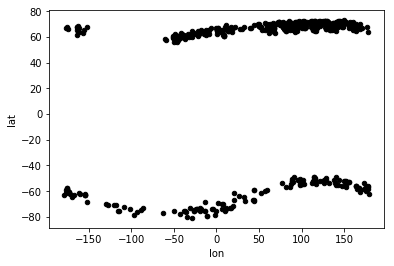

In [17]:
coincidentEvents.plot.scatter('lon', 'lat', c='k');

# Calculate the CDF Attempt 1
The microburst CDF at a separation $d$ is defined as the fraction of coincident microbursts observed at distance d to all the coincident microbursts in other words,

$$
CDF(d) = \frac{coincident > d}{all \ coincident}
$$

The intuitive way to think about this is with an example. When $d = 0$ km, the CDF = 1 i.e. 100% of microbursts were larger than $d$ and when $d = 25$ km the CDF = 0.4 i.e 40% of microbursts had a scale size larger than $d$.

First Calculate the total number of coincident microbursts

In [18]:
totalEvents = len(coincidentEvents); print(totalEvents)

662


Now iterate over each separation bin and calculate the CDF

In [19]:
cdf = np.array([(coincidentEvents['Dist_Total'] >= di).sum()/totalEvents for di in bins])
num = np.array([(coincidentEvents['Dist_Total'] >= di).sum() for di in bins])

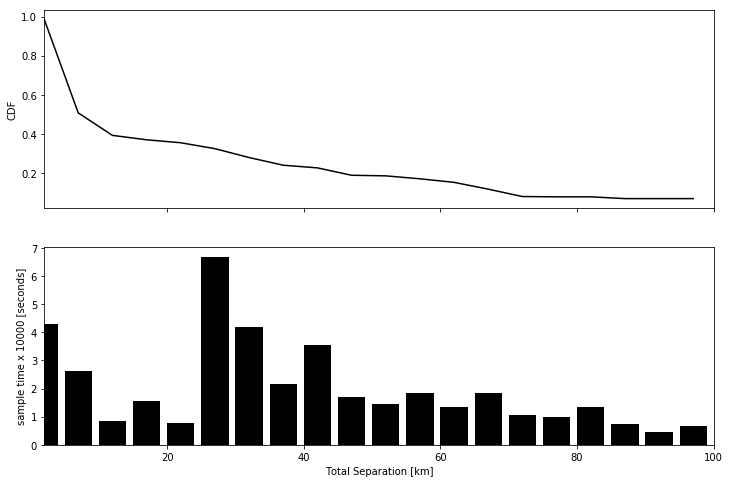

In [20]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 8))
ax[0].plot(bins, cdf, 'k'); ax[0].set_ylabel('CDF');
ax[1].bar(E.index, E['Seconds']/10000, width=0.8*bin_width, color='k')
ax[1].set_ylabel('sample time x 10000 [seconds]'); ax[1].set_xlabel('Total Separation [km]')
ax[0].set_xlim(E.index[0], MAX_SEP);

## Calculate the PDF
by just taking the derivative of the CDF and constraining the area to 1.

In [21]:
pdf = np.convolve([-1, 1], cdf, mode='valid')/bin_width

In [22]:
print('Integral of the microburst PDF', round(sum(pdf), 2)*(E.index[1]-E.index[0]))

Integral of the microburst PDF 0.8999999999999999


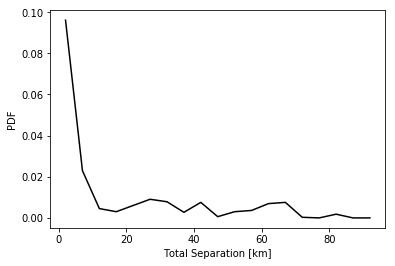

In [23]:
plt.plot(bins[:-1], pdf, 'k'); plt.xlabel('Total Separation [km]'); plt.ylabel('PDF');

In [24]:
# if WRITE_CDF_TO_FILE:
#     data = np.vstack((bins[:-1], cdf[:-1], pdf)).T
#     pd.DataFrame(data=data).to_csv('microburst_cdf_pdf_v0.csv', 
#                                    header=['Dist_Total', 'CDF', 'PDF'], index=False)

# Calculate the CDF Attempt 2
Here I attempt to account for the number of seconds that AC-6 took data togeather to remove a bias that comes from certain separations having more data than other separations. To take the exposure time into account, I reformulate the CDF in the following functional form

$$
CDF(d) = \frac{(coincident > d)/E(d, \inf)}{(all \ coincident)/E(0, \inf)} = \Big(\frac{(coincident > d)}{(all \ coincident)}\Big) \Big(\frac{E(0, \inf)}{E(d, \inf)}\Big)
$$

Visualize how the $E(0, \inf)/E(d, \inf)$ term looks like as a function of d

In [25]:
weights = [E.loc[E.index[0]:MAX_SEP].sum()/E.loc[d:MAX_SEP].sum() for d in range(E.index[0], MAX_SEP+1, bin_width)]

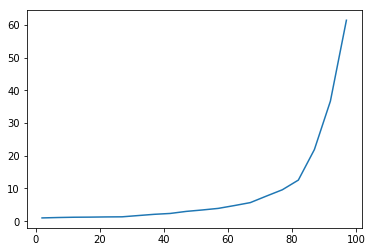

In [26]:
plt.plot(E.loc[E.index[0]:MAX_SEP].index, weights);

In [27]:
cdf2 = np.array([(coincidentEvents['Dist_Total'] >= di).sum()/totalEvents*wi 
                 for di, wi in zip(bins, weights)])
cdf2 = cdf2.flatten()

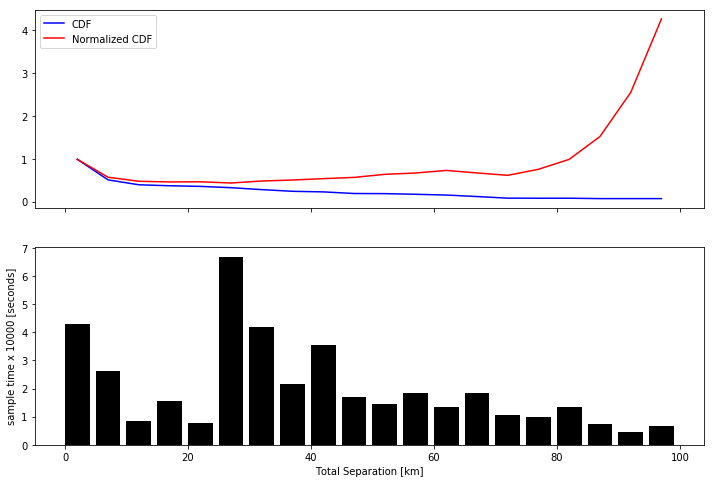

In [28]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 8))
ax[0].plot(bins, cdf, 'b', label='CDF')
ax[0].plot(bins, cdf2, 'r', label='Normalized CDF')
ax[0].legend()
ax[1].bar(E.loc[0:MAX_SEP].index, E['Seconds'].loc[0:MAX_SEP]/10000, width=0.8*bin_width, color='k')
ax[1].set_ylabel('sample time x 10000 [seconds]'); ax[1].set_xlabel('Total Separation [km]');


In [29]:
(coincidentEvents['Dist_Total'] >= 100).sum()

45

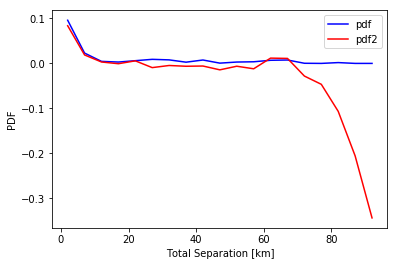

In [30]:
pdf2 = np.convolve([-1, 1], cdf2, mode='valid')/bin_width
plt.plot(bins[:-1], pdf, 'b', label='pdf')
plt.plot(bins[:-1], pdf2, 'r', label='pdf2')
plt.xlabel('Total Separation [km]'); plt.ylabel('PDF');
plt.legend();

In [31]:
# if WRITE_CDF_TO_FILE:
#     data = np.vstack((bins[:-1], cdf2[:-1], pdf2)).T
#     df = pd.DataFrame(data=data, columns=['Dist_Total', 'CDF', 'PDF'])
#     df.to_csv('microburst_cdf_pdf_norm_v0.csv', index=False)

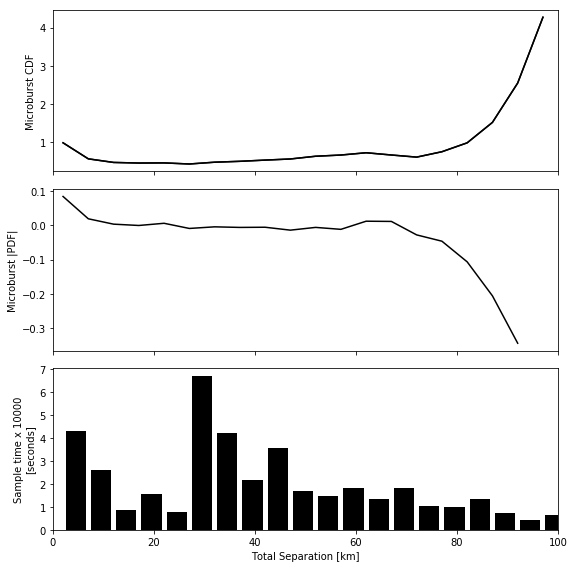

In [32]:
delta_bin = (E.index[1]-E.index[0])
fig, ax = plt.subplots(3, sharex=True, figsize=(8, 8))
ax[0].plot(bins, cdf2, 'k'); ax[0].set_ylabel('Microburst CDF')
ax[0].errorbar(bins, cdf2, c='k', yerr=0); ax[0].set_ylabel('Microburst CDF')
ax[1].plot(bins[:-1], pdf2, 'k'); ax[1].set_ylabel('Microburst |PDF|')
ax[2].bar(E.loc[0:MAX_SEP].index+0.5*delta_bin, E['Seconds'].loc[0:MAX_SEP]/10000, width=0.8*delta_bin, color='k')
ax[2].set_ylabel('Sample time x 10000\n[seconds]'); ax[2].set_xlabel('Total Separation [km]');
plt.tight_layout()
ax[0].set_xlim(0, MAX_SEP);
#plt.savefig('ac6_microburst_cdf_pdf.png')

# Calculate the CDF Attempt 3
Here I attempt to normalize each CDF bin between $d$ and $d + dt$ by the number of samples that AC-6 took data togeather in that bin. This may give the same result as Attempt 2.

$$
CDF(d) = \frac{N'(d)}{N'(0)}
$$ where $N'(d)$ is the adjusted number of detections made in the cumulative bin above a separation $d$. The normalization is then 
$$
N'(d) = \sum_{bin > d} n_{bin} \ W_{bin}
$$ where $N(bin)$ is the number of microbursts in that bin (i.e. between 0 and 5 km), and $W_{bin}$ is the weight factor for that bin which is defined as, $W_{bin} = S_{max}/S_{bin}$. where $S_{max}$ is the bin with the largest number of samples, and $S_{bin}$ is the number of samples in the bin that corresponds to the weights.

First lets define a helper function to get $n$, the number of microbursts between d_i and d_f and apply this function to bin up all microbursts by separation.

In [78]:
n_i = lambda di, df: sum((coincidentEvents['Dist_Total'] >= di) & 
                         (coincidentEvents['Dist_Total'] < df))
n = np.array([n_i(bi, bf) for bi, bf in zip(bins[:-1], bins[1:])]).flatten()

Now calculate the weighting factors, $W_{bin}$ and scale the number of microbursts in each bin by $W$

In [79]:
# need MAX_SEP-bin_width index offset since the n array is one element smaller.
weights = E['Seconds'].loc[0:MAX_SEP-bin_width].max()/E['Seconds'].loc[0:MAX_SEP-bin_width].values
n_weighted = np.multiply(weights, n)

In [80]:
weights

array([ 1.55480281,  2.56331389,  7.91353019,  4.31960898,  8.69939184,
        1.        ,  1.5954552 ,  3.11834714,  1.88488579,  3.94612963,
        4.59748099,  3.64120095,  4.9881379 ,  3.66281665,  6.34137862,
        6.81079019,  4.93220414,  9.0636872 , 15.22452925])

Now calculate the cdf and pdf distributions

In [81]:
cdf3 = np.array([sum(n_weighted[i:])/sum(n_weighted) for i in range(len(n))])
pdf3 = np.convolve([-1, 1], cdf3, mode='valid')/bin_width

Calculate errors in the cdf and pdf due to Poisson counting statistics. The rationalle behind this is we assume that AC-6 as a unit is flying through the radiation belts while being hit by microbursts generated at the equator. The random process that describes the counting of microbursts by AC-6 is the same as counting electrons from a radiation source. So we assume Poisson statistics.

In [86]:
n_prime_std = np.sqrt([sum(n[i:]*weights[i:]**2) for i in range(len(n))])

In [95]:
cdf3_std = cdf3*np.sqrt((n_prime_std/sum(n_weighted))**2 + (n_prime_std[0]/sum(n_weighted))**2)
cdf3_std

array([0.07048361, 0.04579488, 0.03613992, 0.02944763, 0.02735641,
       0.01836851, 0.01720097, 0.01556784, 0.01442829, 0.01259333,
       0.01227409, 0.0104162 , 0.00872252, 0.00439297, 0.0012041 ,
       0.0009882 , 0.0009882 , 0.        , 0.        ])

In [103]:
pdf3_std = np.sqrt(cdf3_std[1:]**2 + cdf3_std[:-1]**2)/bin_width
pdf3_std

array([0.01681084, 0.0116675 , 0.00932364, 0.00803875, 0.00659022,
       0.00503299, 0.00463996, 0.00424515, 0.00383023, 0.00351707,
       0.00321963, 0.0027172 , 0.00195326, 0.000911  , 0.00031154,
       0.00027951, 0.00019764, 0.        ])

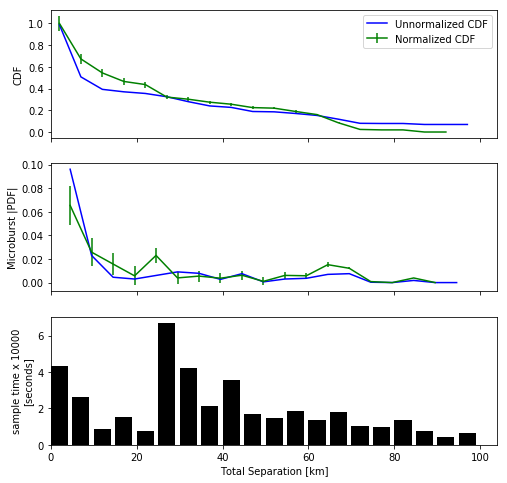

In [105]:
fig, ax = plt.subplots(3, sharex=True, figsize=(8, 8))
# Plot the CDF
ax[0].plot(bins, cdf, 'b', label='Unnormalized CDF')
# ax[0].plot(bins[:-1], cdf3,'g', label='Normalized CDF')
ax[0].errorbar(bins[:-1], cdf3, c='g', yerr=cdf3_std, label='Normalized CDF')
# ax[0].errorbar(bins, cdf, yerr=cdf3_std, c='b', label='Unnormalized CDF')
ax[0].legend()
ax[0].set_ylabel('CDF')

# Plot the PDF
pdf_bins = np.convolve([0.5, 0.5], bins, mode='valid')
ax[1].plot(pdf_bins, pdf, 'b'); 
# ax[1].plot(pdf_bins[:-1], pdf3, 'g');
ax[1].errorbar(pdf_bins[:-1], pdf3, c='g', yerr=pdf3_std);
ax[1].set_ylabel('Microburst |PDF|')

# Plot the number of samples in each Dist_Total bin 
ax[2].bar(E.loc[0:100].index, E['Seconds'].loc[0:100]/10000, width=0.8*bin_width, color='k')
ax[2].set_ylabel('sample time x 10000\n[seconds]'); ax[2].set_xlabel('Total Separation [km]');

ax[0].set_xlim(left=0);
#plt.savefig('ac6_microburst_cdf_pdf_v3_brady.png')

In [71]:
print('Integral of the microburst PDF', scipy.integrate.trapz(pdf3, dx=bin_width))

Integral of the microburst PDF 0.8364544340746086


In [ ]:
if WRITE_CDF_TO_FILE:
    data = np.vstack((bins[:-1], cdf3[:-1], pdf3)).T
    df = pd.DataFrame(data=data, columns=['Dist_Total', 'CDF', 'PDF'])
    df.to_csv('./../data/microburst_cdf_pdf_norm_v3.csv', index=False)

# Microburst Width Statistics
Investigate if there is a difference in widths between microbursts observed at the small and large separations.

In [ ]:
similar_width_events = coincidentEvents[np.isclose(
                            coincidentEvents['peak_width_A'], 
                            coincidentEvents['peak_width_B'], rtol=2)]
similar_width_events_small = similar_width_events[similar_width_events['Dist_Total'] < 10]
similar_width_events_large = similar_width_events[similar_width_events['Dist_Total'] > 50]

plt.hist(similar_width_events_small['peak_width_A'], bins=np.arange(0, 1, 0.1), normed=True, alpha=0.5);
plt.hist(similar_width_events_large['peak_width_A'], bins=np.arange(0, 1, 0.1), normed=True, alpha=0.5);

In [ ]:
similar_width_events_small['peak_width_A'].mean()